In [71]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import torch
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
import SpatialGlue
import rpy2
os.environ['R_HOME'] = '/home/llx/software/miniconda3/envs/pyg_ms/lib/R'

In [4]:
# Specify data type
data_type = '10x'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

In [60]:
# read data
file_fold = '/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/' #please replace 'file_fold' with the download path
st_path = '/home/llx/project/MSI_data/sma/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs/'
adata_omics1=sc.read_visium(st_path,
               count_file='filtered_feature_bc_matrix.h5',
               source_image_path="tissue_hires_image.png")
adata_omics2 = sc.read_h5ad(file_fold + 'adata_SMLED_31.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [61]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca
sc.pp.filter_genes(adata_omics1, min_cells=3)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=350)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics1_high.n_vars-1)

# MASS
sc.pp.filter_genes(adata_omics2, min_cells=3)
sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=350) #
# sc.pp.normalize_total(adata_omics2, target_sum=1e4)
# sc.pp.log1p(adata_omics2)
# adata_omics2 = STMGraph_OM2.clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2_high =  adata_omics2[:, adata_omics2.var['highly_variable']]
adata_omics2.obsm['feat'] = pca(adata_omics2_high, n_comps=adata_omics2_high.n_vars-1)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [62]:
adata_omics2

AnnData object with n_obs × n_vars = 3120 × 352
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'gearyC', 'moranI', 'spatial', 'spatial_neighbors', 'hvg'
    obsm: 'spatial', 'feat'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [63]:
from SpatialGlue.preprocess import construct_neighbor_graph
construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

In [64]:
# define model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, datatype=data_type, device=device)

# train model
output = model.train()

  0%|          | 0/200 [00:00<?, ?it/s]/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/llx/project/jupyternotebook/1_pyg_backup/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 200/200 [00:03<00:00, 50.47it/s]

Model training finished!



In [65]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

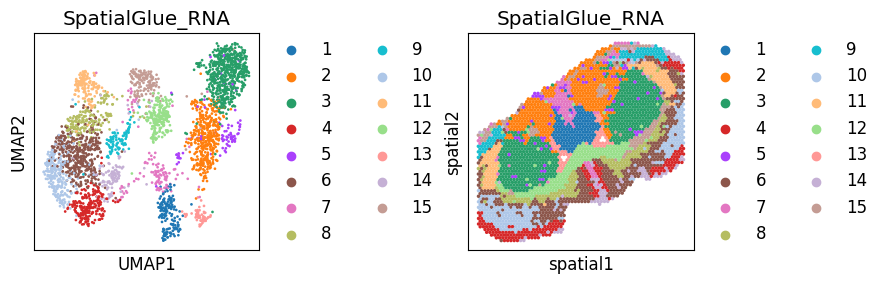

In [66]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='emb_latent_omics1', add_key='SpatialGlue_RNA', n_clusters=15, method=tool, use_pca=False)
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(9, 3))
sc.pp.neighbors(adata, use_rep='emb_latent_omics1', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue_RNA', ax=ax_list[0], title='SpatialGlue_RNA', s=15, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue_RNA', ax=ax_list[1], title='SpatialGlue_RNA', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

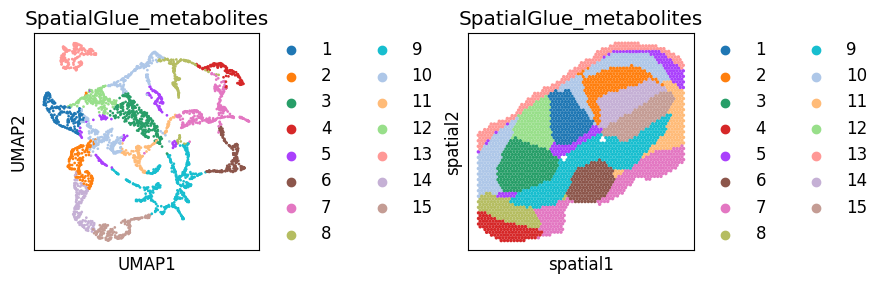

In [67]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='emb_latent_omics2', add_key='SpatialGlue_metabolites', n_clusters=15, method=tool, use_pca=False)
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(9, 3))
sc.pp.neighbors(adata, use_rep='emb_latent_omics2', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue_metabolites', ax=ax_list[0], title='SpatialGlue_metabolites', s=15, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue_metabolites', ax=ax_list[1], title='SpatialGlue_metabolites', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [68]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=15, method=tool, use_pca=False)

fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

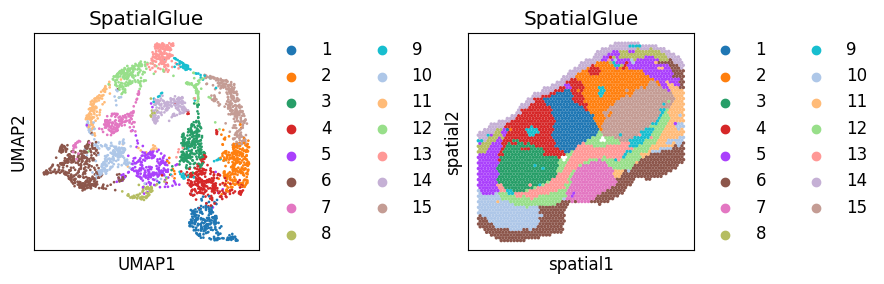

In [69]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(9, 3))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=15, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value enco

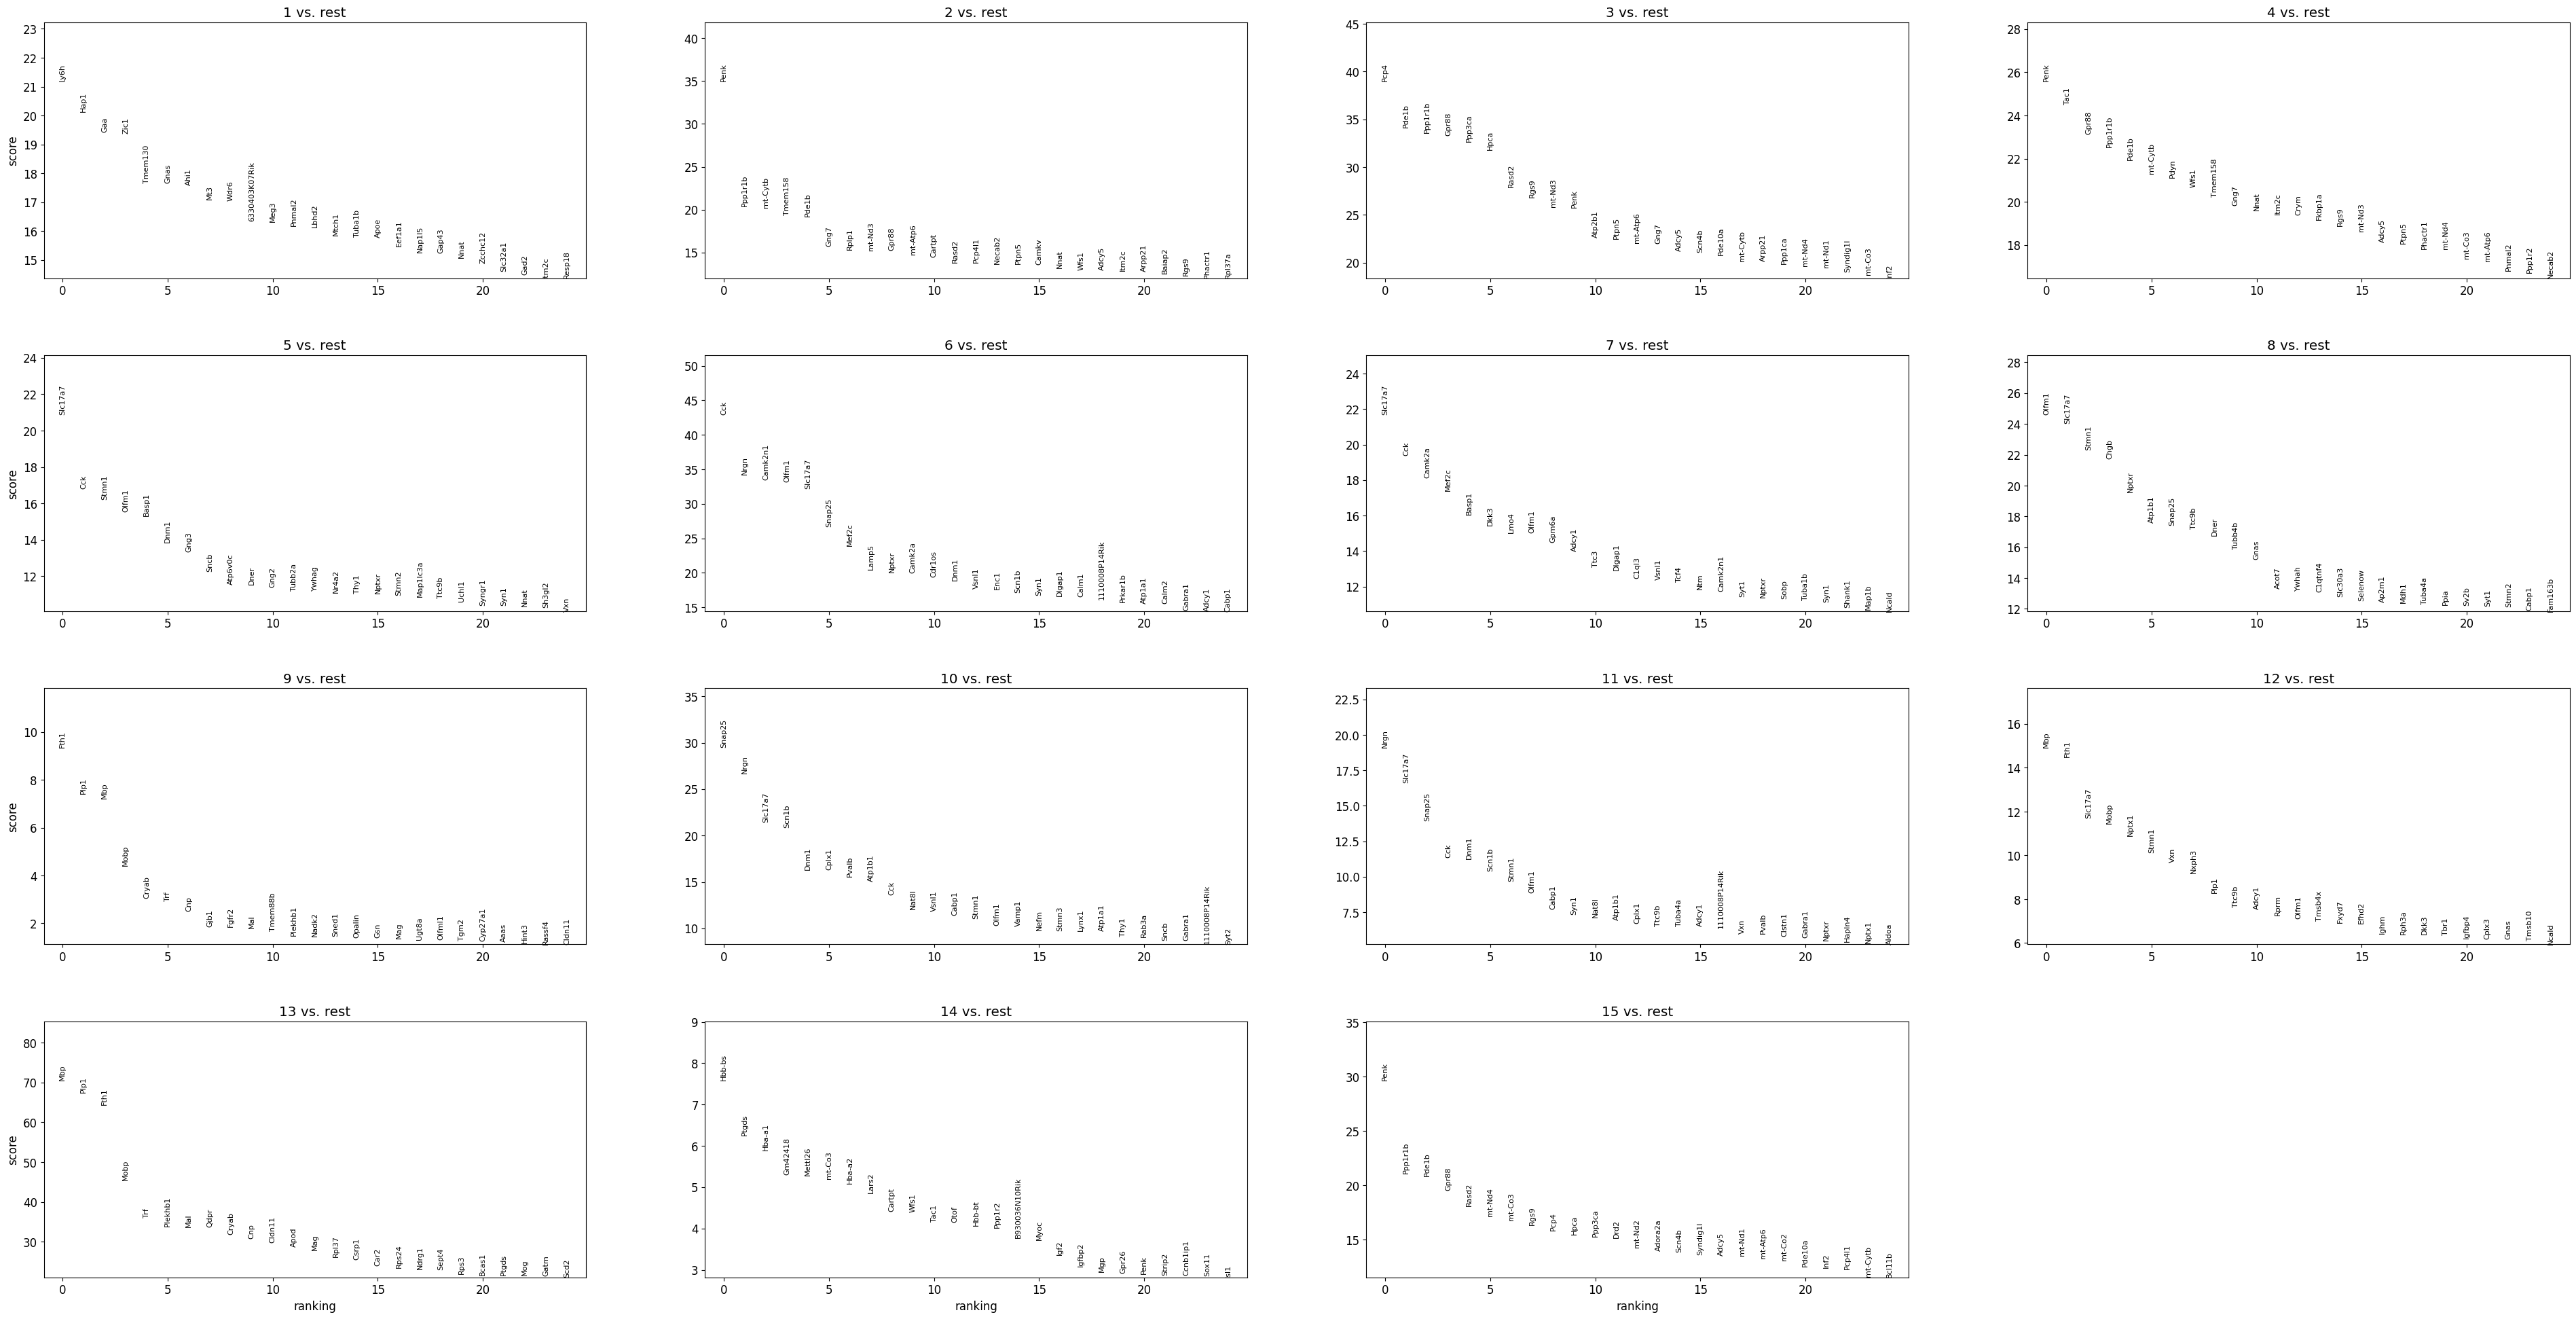

In [72]:
sc.tl.rank_genes_groups(adata, "SpatialGlue", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


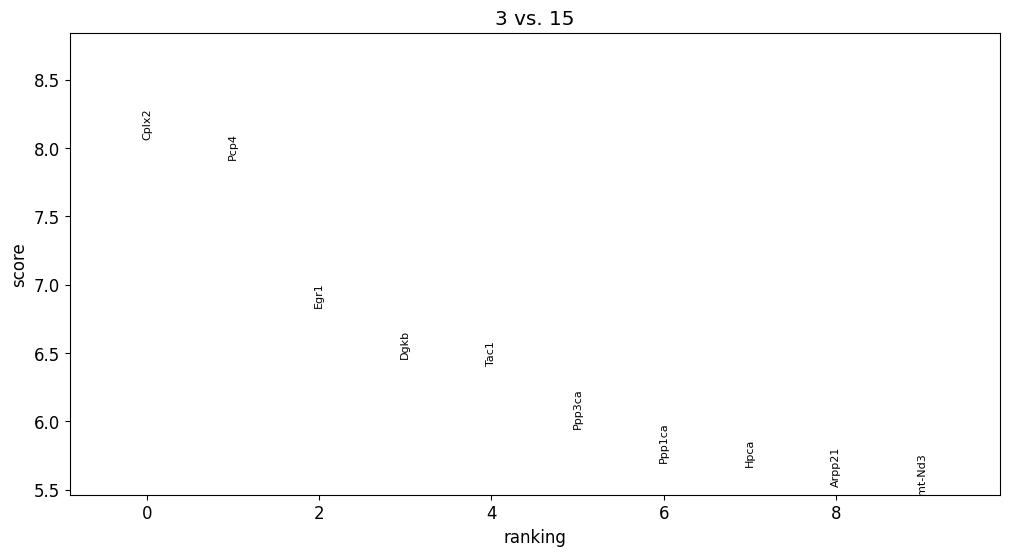

In [90]:
adata.obs['SpatialGlue'] = adata.obs['SpatialGlue'].astype('str')
adata.obs['SpatialGlue'] = adata.obs['SpatialGlue'].astype('category')
sc.tl.rank_genes_groups(adata, "SpatialGlue", groups=["3"], reference="15", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["3"], n_genes=10)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


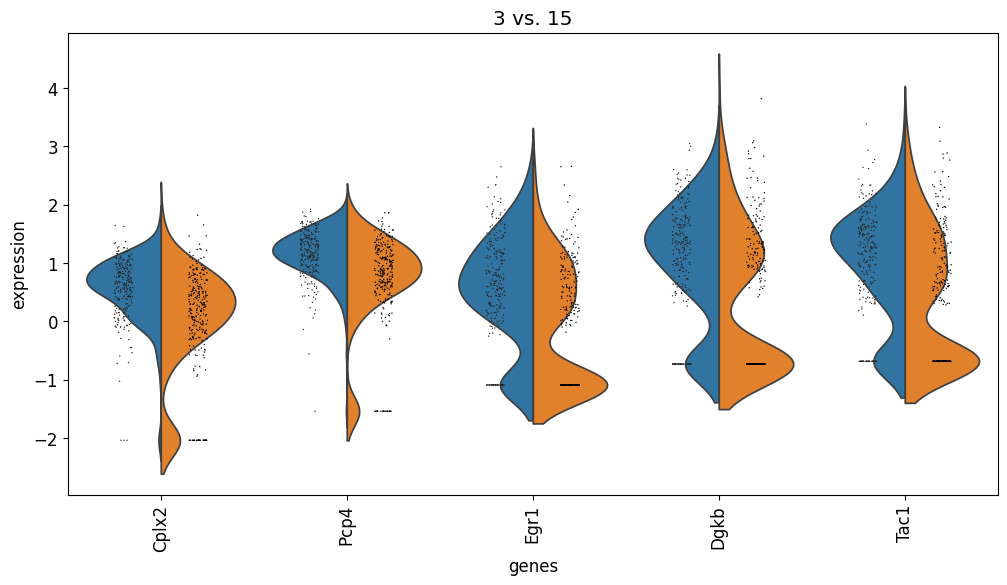

In [96]:
sc.pl.rank_genes_groups_violin(adata, groups="3", n_genes=5)

In [112]:
# adata.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_31_cluster.h5ad')

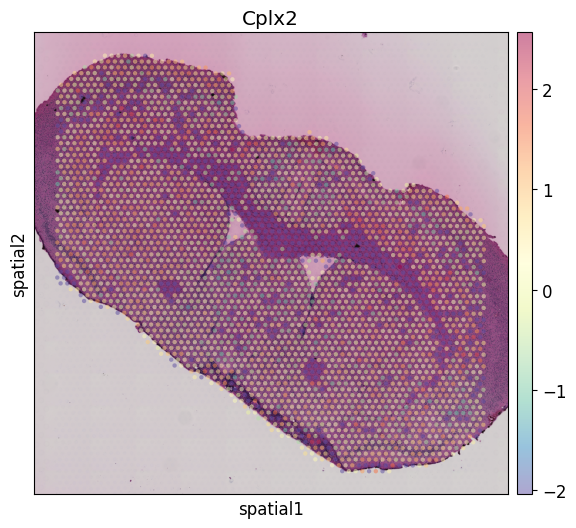

In [100]:
sc.pl.spatial(adata_omics1, 
              img_key="hires", 
              color=['Cplx2'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

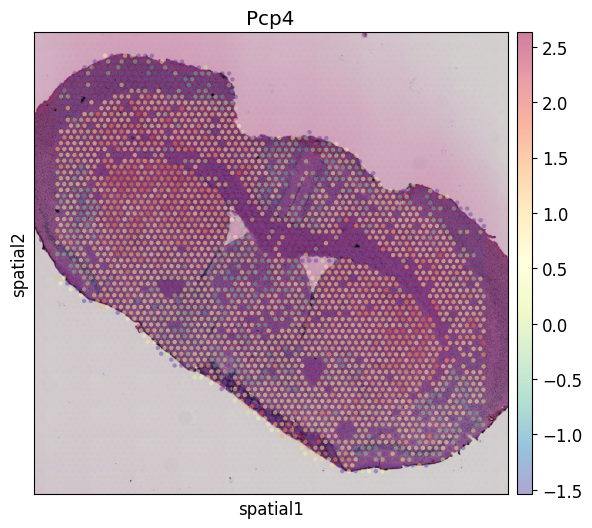

In [101]:
sc.pl.spatial(adata_omics1, 
              img_key="hires", 
              color=['Pcp4'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

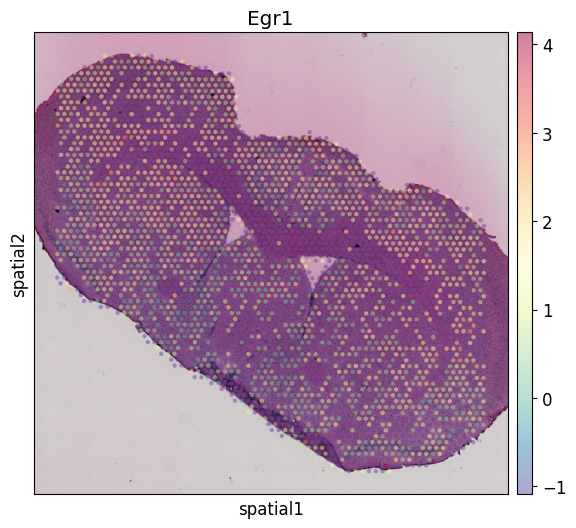

In [106]:
sc.pl.spatial(adata_omics1, 
              img_key="hires", 
              color=['Egr1'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

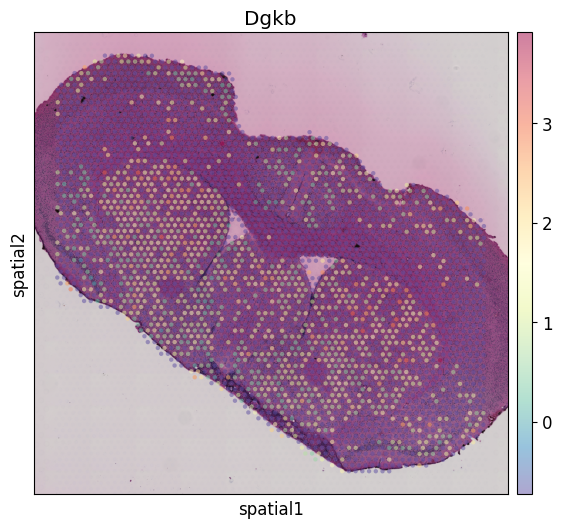

In [103]:
sc.pl.spatial(adata_omics1, 
              img_key="hires", 
              color=['Dgkb'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

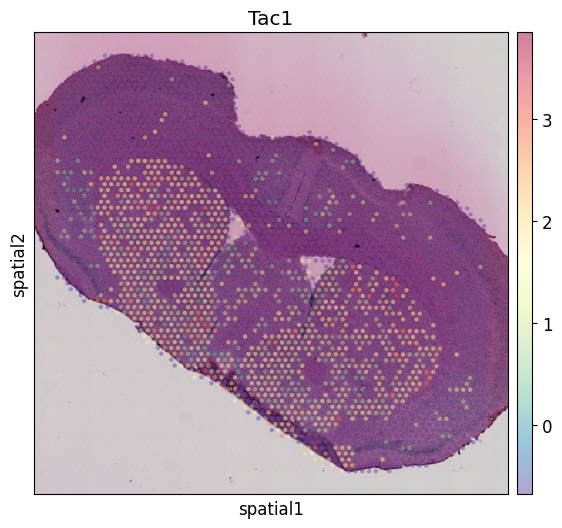

In [105]:
sc.pl.spatial(adata_omics1, 
              img_key="hires", 
              color=['Tac1'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

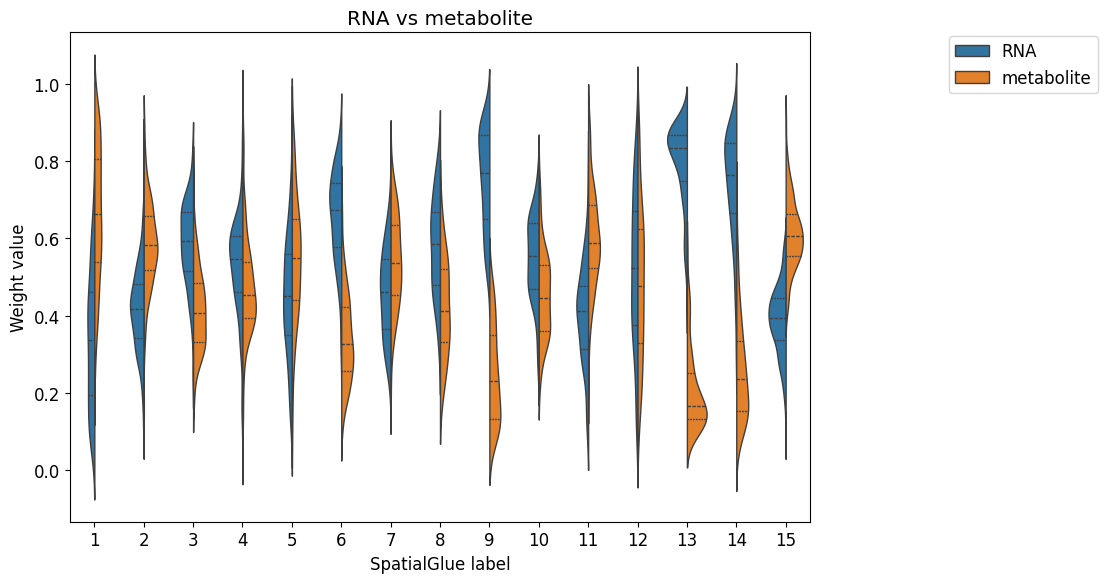

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.rcParams['figure.figsize'] = (12, 6)

# 创建示例数据（假设 adata 是一个 AnnData 对象）
# 这里假设 adata.obsm['alpha'] 和 adata.obs['SpatialGlue'] 已经定义
# 为了演示，使用随机数据代替
import numpy as np

# 创建 DataFrame
df = pd.DataFrame(columns=['RNA', 'metabolite', 'label'])
df['RNA'], df['metabolite'] = adata.obsm['alpha'][:, 0], adata.obsm['alpha'][:, 1]
df['label'] = adata.obs['SpatialGlue'].to_list()

# 重塑数据
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']

# 绘制小提琴图
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                    split=True, inner="quart", linewidth=1)

# 设置标题和标签
ax.set_title('RNA vs metabolite')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

# 调整布局
plt.tight_layout(w_pad=0.05)

# 显示图形
plt.show()